In [462]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math as m
from scipy.integrate import quad
from scipy.special import spherical_jn
from mpl_toolkits.mplot3d import axes3d
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
from matplotlib import rc
import re

def const(H0, OM, OB, OC):
    
    h = H0/100
    
    OMEGA_M = OM
    OMEGA_B = OB
    OMEGA_C = OC

    omega_m = OMEGA_M * (h**2)
    omega_b = OMEGA_B * (h**2)
    omega_c = OMEGA_C * (h**2) 

    a_rec = 1/1100
    a_eq_1 = 24000*omega_m
    alpha = m.sqrt(a_rec*a_eq_1)

    x_rec = (m.sqrt(1+(alpha**2))-1)/alpha

    sigma = 0.03
    tr = 284
    t0 = 6400

    x_s = 0.6*(omega_m**(1/4))*(omega_b**(-1/2))*(a_rec**(3/4))
    k_d = 1/m.sqrt((2*x_s**2)+((sigma**2)*(x_rec**2)))
    K_D = k_d/tr
    
    return OMEGA_B, OMEGA_C, OMEGA_M, omega_b, omega_c, omega_m, a_rec, a_eq_1, alpha, x_rec, sigma, tr, t0, x_s, k_d, K_D, h

def VacFlucInit(k,x):

	etha = (2*alpha) * ((alpha*x)+1) / (((alpha*x)**2)+(2*alpha*x))
	phi = 1
	d_n = -2*phi
	d_c = 3*d_n/4
	v_n = -k*d_n/(4*etha)
	v_c = v_n

	return [phi,d_c,v_c,d_n,v_n]

def VacFluc(X,x,k):

	PHI = X[0]
	D_C = X[1]
	V_C = X[2]
	D_N = X[3]
	V_N = X[4]

	etha = (2*alpha) * ((alpha*x)+1) / (((alpha*x)**2)+(2*alpha*x))
	y = (2*alpha*x)+((alpha*x)**2)
	y_c = (y*OMEGA_C)/(OMEGA_M)
	y_b = (y*OMEGA_B)/(OMEGA_M)

	dPHIdx = (-etha * PHI) + ((3*(etha**2)/(2*k))*(((V_N*((4/3)+y-y_c))+(V_C*y_c))/(1+y)))
	dD_Cdx = (-k * V_C) + (3 * dPHIdx)
	dV_Cdx = (-etha * V_C) + (k * PHI)
	dD_Ndx = ((-4 * k * V_N)/3) + (4 * dPHIdx)
	dV_Ndx = ((1/(1+(3*y_b/4)))*((-3*y_b*etha*V_N/4)+(k*D_N/4)))+(k*PHI)

	return [dPHIdx, dD_Cdx, dV_Cdx, dD_Ndx, dV_Ndx]

def Variable_cal(k_min, k_max, step):
	x0 = 0.001
	x = np.linspace(x0, x_rec)
	var_x_rec = []

	for i in np.arange(k_min, k_max, step):
		X0 = VacFlucInit(i,x0)
		k = i
		sol = odeint(VacFluc, X0, x, args=(k,))
		var = [k,((sol[:,0][-1])+(sol[:,3][-1]/4)),(sol[:,4][-1])]
# 		print(var)
		var_x_rec.append(var)
	
	return var_x_rec, step, x
	
def Spectrum(tab_var, x, step, f_l, l_l, l_step):

	Powers = []
	L = np.arange(f_l, l_l, l_step)
	for i in L:

		k = [j[0] for j in tab_var]
		a = [j[1] for j in tab_var]
		b = [j[2] for j in tab_var]
		dk = step

		func_var = list(map(lambda k,a,b:(2)*i*(i+1)*((a*spherical_jn(i,(t0-tr)*k/tr,derivative=False)+b*spherical_jn(i,(t0-tr)*k/tr,1))**2)*np.exp(-(k/(tr*K_D))**2)*(k**(-1.04)), k,a,b))
		integ = np.sum([j*dk for j in func_var])
		print(i,">>>>>>>>",integ)
		Powers.append(integ)

	return L, Powers

def Smooth_func(x_lst, y_lst, number):

	x_new = []
	y_new = []
	counter = 0

	while counter != len(x_lst) - 1 - int((number-1)/2) :

		x = [i for i in x_lst[counter:counter+number]]
		y = [j for j in y_lst[counter:counter+number]]
		x_mean = np.mean(x)
		y_mean = np.mean(y)
		x_new.append(x_mean)
		y_new.append(y_mean)
		counter += 1

	return x_new, y_new

In [466]:
#    OMEGA_M = 0.3089
#    OMEGA_B = 0.0486
#    OMEGA_C = 0.2589
#    H0 = 67.74
names = [['bob','bog','bsb','bsg'],['mob','mog','msb','msg'],['cob','cog','csb','csg'],['hob','hog','hsb','hsg']]
limits = [np.arange(0.04,0.15,0.01),np.arange(0.3,1.2,0.1),np.arange(0.2,0.31,0.01),np.arange(50,105,5)]
cb_name = ['\Omega_b', '\Omega_m', '\Omega_c', '\H_0']
y_tick_v = [[0, .2, .4, .6, .8, 1],[0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6, 1.8],[0, .2, .4, .6, .8, 1],[0, .2, .4, .6, .8, 1]]

In [476]:
t_powers = []
# t = limits[3]
t = [67.74]
for i, j in enumerate(t):
	OMEGA_B,OMEGA_C,OMEGA_M,omega_b,omega_c,omega_m,a_rec,a_eq_1,alpha,x_rec,sigma,tr,t0,x_s,k_d,K_D,h = const(j,0.3089,0.0486,0.2589)
	coup_ans, step, x = Variable_cal(0.01,300,0.05)
	L, Powers = Spectrum(coup_ans, x, step, 1, 1500, 2)
	t_powers.append(Powers)

1 >>>>>>>> 0.15478850771929267
3 >>>>>>>> 0.1500572925922023
5 >>>>>>>> 0.14933820402178827
7 >>>>>>>> 0.14982041370263308
9 >>>>>>>> 0.15086437557099164
11 >>>>>>>> 0.15218966783830812
13 >>>>>>>> 0.15363995134387876
15 >>>>>>>> 0.15512028272125306
17 >>>>>>>> 0.1565719796921744
19 >>>>>>>> 0.15795928381280191
21 >>>>>>>> 0.1592630801701679
23 >>>>>>>> 0.16047612952634976
25 >>>>>>>> 0.1616000193043219
27 >>>>>>>> 0.1626432679896701
29 >>>>>>>> 0.16361981868002615
31 >>>>>>>> 0.16454797126830015
33 >>>>>>>> 0.16544924851700116
35 >>>>>>>> 0.16634759631155682
37 >>>>>>>> 0.1672690428922488
39 >>>>>>>> 0.1682406162910327
41 >>>>>>>> 0.16929030963773367
43 >>>>>>>> 0.17044654574582854
45 >>>>>>>> 0.17173772808389373
47 >>>>>>>> 0.17319199033114993
49 >>>>>>>> 0.17483690690028314
51 >>>>>>>> 0.176699045534277
53 >>>>>>>> 0.17880416139865005
55 >>>>>>>> 0.18117640701257673
57 >>>>>>>> 0.18383882472889376
59 >>>>>>>> 0.1868127166238036
61 >>>>>>>> 0.19011754490452112
63 >>>>>>>> 0.193771106

515 >>>>>>>> 0.34958436092112183
517 >>>>>>>> 0.35225476405387923
519 >>>>>>>> 0.35515879567239267
521 >>>>>>>> 0.3582828863116422
523 >>>>>>>> 0.36161271861904476
525 >>>>>>>> 0.36513327939629703
527 >>>>>>>> 0.36882892016211843
529 >>>>>>>> 0.37268340249938764
531 >>>>>>>> 0.3766799643363818
533 >>>>>>>> 0.3808013816652689
535 >>>>>>>> 0.3850300260542966
537 >>>>>>>> 0.38934792351779435
539 >>>>>>>> 0.3937368216012581
541 >>>>>>>> 0.3981782548898205
543 >>>>>>>> 0.4026536041787547
545 >>>>>>>> 0.4071441622673769
547 >>>>>>>> 0.4116312011481937
549 >>>>>>>> 0.41609603285476443
551 >>>>>>>> 0.42052007151013576
553 >>>>>>>> 0.4248849018908564
555 >>>>>>>> 0.42917233752673345
557 >>>>>>>> 0.4333644814073078
559 >>>>>>>> 0.4374437820499485
561 >>>>>>>> 0.44139309871275806
563 >>>>>>>> 0.4451957558764052
565 >>>>>>>> 0.4488355940246957
567 >>>>>>>> 0.4522970207106347
569 >>>>>>>> 0.4555650715070938
571 >>>>>>>> 0.45862544389596194
573 >>>>>>>> 0.46146454956499233
575 >>>>>>>> 0.46406955586

1019 >>>>>>>> 0.1373624848008284
1021 >>>>>>>> 0.13766120820155128
1023 >>>>>>>> 0.1378636844883739
1025 >>>>>>>> 0.13796790675266724
1027 >>>>>>>> 0.13797222674035553
1029 >>>>>>>> 0.13787535573045817
1031 >>>>>>>> 0.13767636483804058
1033 >>>>>>>> 0.13737468449242732
1035 >>>>>>>> 0.1369701011640568
1037 >>>>>>>> 0.13646275479262315
1039 >>>>>>>> 0.13585313489024822
1041 >>>>>>>> 0.13514207354505062
1043 >>>>>>>> 0.13433073994010888
1045 >>>>>>>> 0.13342063161396486
1047 >>>>>>>> 0.1324135663092436
1049 >>>>>>>> 0.13131167097813476
1051 >>>>>>>> 0.1301173720188124
1053 >>>>>>>> 0.1288333837398703
1055 >>>>>>>> 0.12746269500385665
1057 >>>>>>>> 0.12600855695246663
1059 >>>>>>>> 0.12447446881751549
1061 >>>>>>>> 0.1228641615614148
1063 >>>>>>>> 0.12118158488756406
1065 >>>>>>>> 0.11943089009687304
1067 >>>>>>>> 0.11761641349499256
1069 >>>>>>>> 0.11574266097906978
1071 >>>>>>>> 0.11381428907123496
1073 >>>>>>>> 0.11183608892721839
1075 >>>>>>>> 0.10981296748998866
1077 >>>>>>>> 0.10774

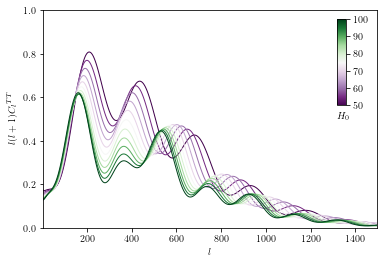

In [473]:
fig, ax = plt.subplots()
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
ax.set_xlim(np.min(L), np.max(L))
ax.set_ylim(np.min(t_powers), np.max(t_powers))
line_seg = LineCollection([np.column_stack((L,power)) for power in t_powers], linewidths=(1), linestyles='solid')
line_seg.set_array(t)
# line_seg.cmap = plt.cm.RdGy
line_seg.cmap = plt.cm.PRGn
ax.add_collection(line_seg)
# ax.semilogx()
# ax.set_xticks([10,100,1000])
ax.set_xticks([200,400,600,800,1000,1200,1400])
ax.set_yticks([0, .2, .4, .6, .8, 1])
plt.xlabel(r'${l}$')
plt.ylabel(r'${l(l+1){C_l}^{TT}}$')
plt.text(0.898, 0.51,r'$H_0$', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
cbaxes = fig.add_axes([0.807, 0.55, 0.02, 0.3]) 
fig.colorbar(line_seg, cax=cbaxes)
file_name =  "/Users/Muhammad/Desktop/CMBPlots/Plots/PRGn.eps"
fig.savefig(file_name,format='eps', dpi=1000)

In [435]:
#0.064-0.157--0.898-0.807


In [474]:
import pandas as pd

my_df = pd.DataFrame(t_powers)
my_df.to_csv('/Users/Muhammad/Desktop/CMBPlots/H0.csv', index=False, header=False)

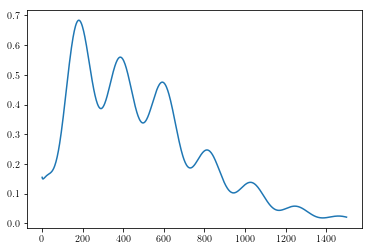

In [481]:
plt.plot(L,t_powers[0])